In [9]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [10]:

#Load data
DATA_PATH = "/content/household_power_consumption.txt"  # <- your uploaded file name

assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}. Please upload it to /content."

df = pd.read_csv(
    DATA_PATH,
    sep=";",
    na_values="?",
    low_memory=False
)

#Combine date+time into Datetime index
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df.drop(columns=["Date", "Time"]).set_index("Datetime")

#Convert to float32 for memory + speed
df = df.astype("float32")

#Drop missing rows (simple and safe)
df = df.dropna()

print("Raw rows:", len(df))
display(df.head())


Raw rows: 2049280


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


In [11]:
# Hourly resample
df_h = df.resample("1H").mean().dropna()

#We'll use Global_active_power as main "demand" signal (kW)
target_col = "Global_active_power"
assert target_col in df_h.columns, f"{target_col} not found in columns!"

print("Hourly rows:", len(df_h))
display(df_h.head())


Hourly rows: 34168


/tmp/ipython-input-3857717522.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_h = df.resample("1H").mean().dropna()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643875,18.099998,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580154,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232498,14.503333,0.0,1.433333,16.683332
2006-12-16 20:00:00,3.268567,0.075100,234.071503,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158661,13.046666,0.0,0.416667,17.216667


In [12]:
#Feature engineering
data = df_h.copy()

#Calendar features (approximate the paper's time-pattern influence)
data["hour"] = data.index.hour.astype("float32")
data["dayofweek"] = data.index.dayofweek.astype("float32")
data["month"] = data.index.month.astype("float32")

#Lag features (important for time-series)
data["lag_1h"] = data[target_col].shift(1)
data["lag_24h"] = data[target_col].shift(24)

#Rolling stats(its noveloty i made in paper)
#Helps reduce false alarms due to daily patterns.
data["roll_mean_24h"] = data[target_col].rolling(24).mean()
data["roll_std_24h"] = data[target_col].rolling(24).std()

data = data.dropna()
print("After features:", data.shape)
display(data.head())


After features: (34144, 14)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,lag_1h,lag_24h,roll_mean_24h,roll_std_24h
Datetime,,,,,,,,,,,,,,
2006-12-17 17:00:00,3.406767,0.166633,234.229828,14.509999,0.0,0.466667,16.816668,17.0,6.0,12.0,3.326033,4.222889,2.465140,0.752521
2006-12-17 18:00:00,3.697100,0.135067,234.372330,15.750000,0.0,0.000000,16.833334,18.0,6.0,12.0,3.406767,3.632200,2.467844,0.757001
2006-12-17 19:00:00,2.908400,0.265167,233.195663,12.516666,0.0,0.516667,16.683332,19.0,6.0,12.0,3.697100,3.400233,2.447351,0.737057
2006-12-17 20:00:00,3.361500,0.271500,236.426498,14.276667,0.0,1.116667,17.116667,20.0,6.0,12.0,2.908400,3.268567,2.451224,0.741788
2006-12-17 21:00:00,3.040767,0.267967,239.104172,12.716666,0.0,1.200000,17.500000,21.0,6.0,12.0,3.361500,3.056467,2.450569,0.741237


In [13]:
#Train/test split (chronological)
split = int(len(data) * 0.8)
train_df = data.iloc[:split].copy()
test_df  = data.iloc[split:].copy()

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (27315, 14) Test: (6829, 14)


In [14]:
#Scaling
feature_cols = list(data.columns)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df[feature_cols])
test_scaled  = scaler.transform(test_df[feature_cols])

train_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=feature_cols)
test_scaled  = pd.DataFrame(test_scaled, index=test_df.index, columns=feature_cols)


In [15]:
# Sequence builder

def make_sequences(df_scaled, window=24, target_name=target_col):
    """
    Returns:
      X: (N, window, num_features)
      y: (N,) next-step target (for forecasting)
      idx: timestamps aligned to y
    """
    values = df_scaled.values.astype("float32")
    target_idx = df_scaled.columns.get_loc(target_name)

    X, y, idx = [], [], []
    for i in range(window, len(df_scaled) - 1):
        X.append(values[i-window:i])
        y.append(values[i+1, target_idx])
        idx.append(df_scaled.index[i+1])
    return np.array(X), np.array(y), np.array(idx)

WINDOW = 24  #24 hours history
Xf_train, yf_train, idxf_train = make_sequences(train_scaled, window=WINDOW)
Xf_test,  yf_test,  idxf_test  = make_sequences(test_scaled,  window=WINDOW)

print("Forecast train X:", Xf_train.shape, "y:", yf_train.shape)
print("Forecast test  X:", Xf_test.shape,  "y:", yf_test.shape)


Forecast train X: (27290, 24, 14) y: (27290,)
Forecast test  X: (6804, 24, 14) y: (6804,)


In [16]:

#GRU Forecaster

def build_gru_forecaster(num_features):
    inp = layers.Input(shape=(WINDOW, num_features))
    x = layers.GRU(32)(inp)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="mse")
    return model

forecaster = build_gru_forecaster(Xf_train.shape[-1])

es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

hist_f = forecaster.fit(
    Xf_train, yf_train,
    validation_split=0.1,
    epochs=20,
    batch_size=128,
    callbacks=[es],
    verbose=1
)

#Predictions (scaled)
pred_train = forecaster.predict(Xf_train, verbose=0).reshape(-1)
pred_test  = forecaster.predict(Xf_test,  verbose=0).reshape(-1)

print("Forecaster done.")


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7487 - val_loss: 0.6450
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5885 - val_loss: 0.6077
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5561 - val_loss: 0.5843
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5312 - val_loss: 0.5610
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5036 - val_loss: 0.5379
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4808 - val_loss: 0.5249
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4669 - val_loss: 0.5178
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4576 - val_loss: 0.5134
Epoch 9/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4503 - val_loss: 0.5109
Epoch 10/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4441 - val_loss: 0.5099
Epoch 11/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4385 - val_loss: 0.5100
Epoch 12/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [17]:

# Add forecasting signals to each timestamp (aligned)

train_feat2 = train_scaled.copy()
test_feat2  = test_scaled.copy()

# Create empty cols
train_feat2["pred_next_scaled"] = np.nan
train_feat2["resid_scaled"] = np.nan
test_feat2["pred_next_scaled"] = np.nan
test_feat2["resid_scaled"] = np.nan

# Fill aligned on idx from sequence builder
train_feat2.loc[idxf_train, "pred_next_scaled"] = pred_train
train_feat2.loc[idxf_train, "resid_scaled"] = (yf_train - pred_train)

test_feat2.loc[idxf_test, "pred_next_scaled"] = pred_test
test_feat2.loc[idxf_test, "resid_scaled"] = (yf_test - pred_test)

#Drop rows that don't have predictions (initial window)
train_feat2 = train_feat2.dropna()
test_feat2  = test_feat2.dropna()

print("Train_feat2:", train_feat2.shape, "Test_feat2:", test_feat2.shape)


Train_feat2: (27290, 16) Test_feat2: (6804, 16)


In [18]:

#GRU Autoencoder (paper-like)

def make_ae_sequences(df_scaled, window=24):
    values = df_scaled.values.astype("float32")
    X, idx = [], []
    for i in range(window, len(df_scaled)):
        X.append(values[i-window:i])
        idx.append(df_scaled.index[i])
    return np.array(X), np.array(idx)

Xa_train, idxa_train = make_ae_sequences(train_feat2, window=WINDOW)
Xa_test,  idxa_test  = make_ae_sequences(test_feat2,  window=WINDOW)

print("AE Train:", Xa_train.shape, "AE Test:", Xa_test.shape)

def build_gru_autoencoder(num_features, lr=0.01):
    # Encoder
    inp = layers.Input(shape=(WINDOW, num_features))
    x = layers.GRU(40, return_sequences=True)(inp)    # paper: 40 units
    x = layers.GRU(20, return_sequences=False)(x)     # paper: 20 units

    # Bottleneck -> Repeat
    x = layers.RepeatVector(WINDOW)(x)

    # Decoder
    x = layers.GRU(20, return_sequences=True)(x)
    x = layers.GRU(40, return_sequences=True)(x)

    out = layers.TimeDistributed(layers.Dense(num_features))(x)

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
    return model

ae_paper = build_gru_autoencoder(Xa_train.shape[-1], lr=0.01)

es_ae = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)

hist_ae = ae_paper.fit(
    Xa_train, Xa_train,
    validation_split=0.1,
    epochs=60,           # paper mentions up to 300, but we cap for speed; early stop keeps it fair
    batch_size=128,      # paper used 68; 128 is faster on CPU and stable
    callbacks=[es_ae],
    verbose=1
)

print("Autoencoder training complete.")


AE Train: (27266, 24, 16) AE Test: (6780, 24, 16)
Epoch 1/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.6233 - val_loss: 0.4350
Epoch 2/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.3624 - val_loss: 0.3714
Epoch 3/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3137 - val_loss: 0.3437
Epoch 4/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2883 - val_loss: 0.3275
Epoch 5/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2728 - val_loss: 0.3204
Epoch 6/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2618 - val_loss: 0.3091
Epoch 7/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2529 - val_loss: 0.2974
Epoch 8/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2472 - val_loss: 0.2915
Epoch 9/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2440 - val_loss: 0.2893
Epoch 10/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2317 - val_loss: 0.2852
Epoch 11/60
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2270 - val_loss

In [19]:

# Reconstruction errors + thresholds

def reconstruction_errors(model, X):
    Xhat = model.predict(X, verbose=0)
    # MSE per sample over time & features
    err = np.mean((X - Xhat) ** 2, axis=(1,2))
    return err.astype("float32")

train_err = reconstruction_errors(ae_paper, Xa_train)
test_err  = reconstruction_errors(ae_paper, Xa_test)

# Baseline threshold (paper-style): mean + 3*std on training reconstruction errors
thr_fixed = train_err.mean() + 3.0 * train_err.std()

print("Fixed threshold:", thr_fixed)

def ema_threshold(errors, alpha=0.05, k=3.0):
    """
    Dynamic threshold:
      EMA_mean(t) + k * EMA_std(t)
    NOVELTY #2: dynamic thresholding (smoother than fixed threshold)
    """
    errors = np.asarray(errors, dtype="float32")
    ema_m = np.zeros_like(errors)
    ema_v = np.zeros_like(errors)
    ema_m[0] = errors[0]
    ema_v[0] = 0.0
    for i in range(1, len(errors)):
        ema_m[i] = alpha * errors[i] + (1 - alpha) * ema_m[i-1]
        dev = errors[i] - ema_m[i]
        ema_v[i] = alpha * (dev * dev) + (1 - alpha) * ema_v[i-1]
    ema_s = np.sqrt(ema_v + 1e-8)
    thr = ema_m + k * ema_s
    return thr, ema_m, ema_s

thr_dyn, ema_m, ema_s = ema_threshold(test_err, alpha=0.05, k=3.0)

# Predictions
pred_fixed = (test_err > thr_fixed).astype(int)
pred_dyn   = (test_err > thr_dyn).astype(int)

print("Anomalies (fixed):", pred_fixed.sum(), " / ", len(pred_fixed))
print("Anomalies (dyn):  ", pred_dyn.sum(),   " / ", len(pred_dyn))


Fixed threshold: 0.5178113
Anomalies (fixed): 152  /  6780
Anomalies (dyn):   33  /  6780


In [20]:

# 11) Create labeled test by injecting anomalies (for metrics + comparison)

def inject_anomalies(series, spike_frac=0.01, drop_frac=0.01, drift_frac=0.01, seed=42):
    """
    Returns:
      series_injected, labels (1=anomaly)
    """
    rng = np.random.default_rng(seed)
    x = series.copy().astype("float32")
    n = len(x)
    labels = np.zeros(n, dtype=int)

    # Spike anomalies
    m_spike = int(n * spike_frac)
    idx_spike = rng.choice(n, size=m_spike, replace=False)
    x[idx_spike] = x[idx_spike] + (3.0 * x.std())  # big jump
    labels[idx_spike] = 1

    # Dropout anomalies (sudden low / near zero)
    m_drop = int(n * drop_frac)
    idx_drop = rng.choice(n, size=m_drop, replace=False)
    x[idx_drop] = x[idx_drop] * 0.1
    labels[idx_drop] = 1

    # Drift anomalies (a continuous segment)
    m_drift = int(n * drift_frac)
    if m_drift >= 10:
        start = rng.integers(0, n - m_drift)
        x[start:start+m_drift] = x[start:start+m_drift] + np.linspace(0, 2.0 * x.std(), m_drift).astype("float32")
        labels[start:start+m_drift] = 1

    return x, labels

# We'll inject into the *target feature only*, then rebuild test features & run AE again quickly.

test_raw = test_df.copy()
injected_target, y_true_point = inject_anomalies(test_raw[target_col].values, spike_frac=0.01, drop_frac=0.01, drift_frac=0.01, seed=SEED)
test_raw[target_col] = injected_target

# Recreate engineered features for injected test (same as before)
test_inj = test_raw.copy()
test_inj["hour"] = test_inj.index.hour.astype("float32")
test_inj["dayofweek"] = test_inj.index.dayofweek.astype("float32")
test_inj["month"] = test_inj.index.month.astype("float32")
test_inj["lag_1h"] = test_inj[target_col].shift(1)
test_inj["lag_24h"] = test_inj[target_col].shift(24)
test_inj["roll_mean_24h"] = test_inj[target_col].rolling(24).mean()
test_inj["roll_std_24h"] = test_inj[target_col].rolling(24).std()
test_inj = test_inj.dropna()

# Scale using TRAIN scaler (no leakage)
test_inj_scaled = scaler.transform(test_inj[feature_cols])
test_inj_scaled = pd.DataFrame(test_inj_scaled, index=test_inj.index, columns=feature_cols)

# Add forecast signals quickly:
# We'll reuse the same forecaster trained earlier (fast), but need sequences again.
Xf_inj, yf_inj, idxf_inj = make_sequences(test_inj_scaled, window=WINDOW)
pred_inj = forecaster.predict(Xf_inj, verbose=0).reshape(-1)

test_inj_feat2 = test_inj_scaled.copy()
test_inj_feat2["pred_next_scaled"] = np.nan
test_inj_feat2["resid_scaled"] = np.nan
test_inj_feat2.loc[idxf_inj, "pred_next_scaled"] = pred_inj
test_inj_feat2.loc[idxf_inj, "resid_scaled"] = (yf_inj - pred_inj)
test_inj_feat2 = test_inj_feat2.dropna()

# AE sequences + errors
Xa_inj, idxa_inj = make_ae_sequences(test_inj_feat2, window=WINDOW)
inj_err = reconstruction_errors(ae_paper, Xa_inj)

# Align point labels to AE timestamps (use label at the sequence "current time")
# We'll mark a sequence as anomalous if the CURRENT time point was injected anomaly.
# Need to align y_true_point to idxa_inj.
labels_series = pd.Series(y_true_point, index=test_df.index)  # original test index length
labels_series = labels_series.reindex(test_inj_feat2.index).fillna(0).astype(int)

y_true = labels_series.loc[idxa_inj].values.astype(int)

# Baseline fixed vs EMA dynamic
pred_fixed_inj = (inj_err > thr_fixed).astype(int)
thr_dyn_inj, _, _ = ema_threshold(inj_err, alpha=0.05, k=3.0)
pred_dyn_inj = (inj_err > thr_dyn_inj).astype(int)

def metrics(y, yhat):
    p, r, f, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    acc = accuracy_score(y, yhat)
    return p, r, f, acc

m_fixed = metrics(y_true, pred_fixed_inj)
m_dyn   = metrics(y_true, pred_dyn_inj)

print("Fixed threshold metrics  (P,R,F1,Acc):", m_fixed)
print("EMA dynamic metrics      (P,R,F1,Acc):", m_dyn)


Fixed threshold metrics  (P,R,F1,Acc): (0.12206572769953052, 0.12807881773399016, 0.125, 0.9461219656601539)
EMA dynamic metrics      (P,R,F1,Acc): (0.029411764705882353, 0.0049261083743842365, 0.008438818565400843, 0.9652161042036708)


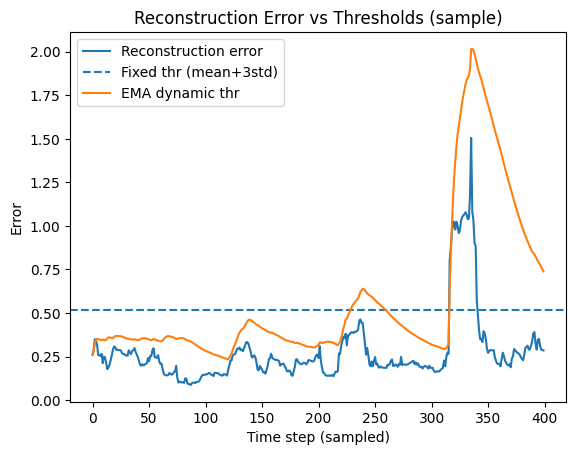

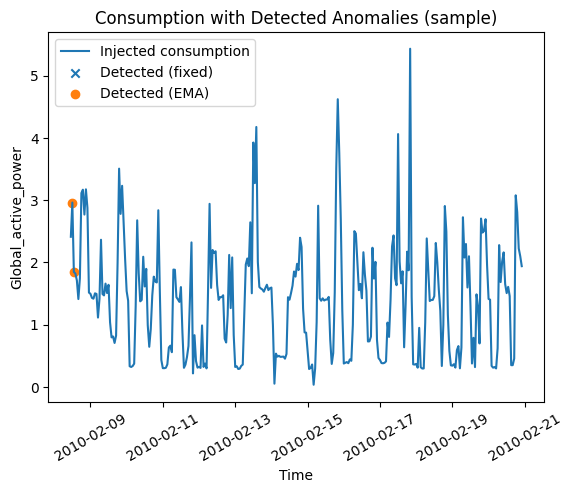

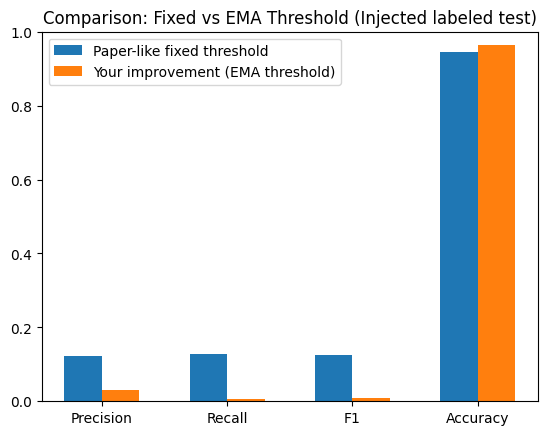

Confusion Matrix (Fixed):
 [[6366  187]
 [ 177   26]]
Confusion Matrix (EMA):
 [[6520   33]
 [ 202    1]]


In [21]:

# Visualizations
# Reconstruction error + thresholds
plot_n = min(400, len(inj_err))
x = np.arange(plot_n)

plt.figure()
plt.plot(x, inj_err[:plot_n], label="Reconstruction error")
plt.axhline(thr_fixed, linestyle="--", label="Fixed thr (mean+3std)")
plt.plot(x, thr_dyn_inj[:plot_n], label="EMA dynamic thr")
plt.title("Reconstruction Error vs Thresholds (sample)")
plt.xlabel("Time step (sampled)")
plt.ylabel("Error")
plt.legend()
plt.show()

# Timeline anomalies overlay
# Build a readable time axis for a short span
span = min(300, len(idxa_inj))
t = pd.to_datetime(idxa_inj[:span])

plt.figure()
plt.plot(t, test_inj.loc[t, target_col].values, label="Injected consumption")

# Mark detected anomalies (fixed)
anoms_fixed_idx = t[pred_fixed_inj[:span] == 1]
plt.scatter(anoms_fixed_idx, test_inj.loc[anoms_fixed_idx, target_col].values, label="Detected (fixed)", marker="x")

# Mark detected anomalies (dynamic)
anoms_dyn_idx = t[pred_dyn_inj[:span] == 1]
plt.scatter(anoms_dyn_idx, test_inj.loc[anoms_dyn_idx, target_col].values, label="Detected (EMA)", marker="o")

plt.title("Consumption with Detected Anomalies (sample)")
plt.xlabel("Time")
plt.ylabel("Global_active_power")
plt.legend()
plt.xticks(rotation=30)
plt.show()

# Metric comparison bar chart
labels = ["Precision", "Recall", "F1", "Accuracy"]
fixed_vals = list(m_fixed)
dyn_vals   = list(m_dyn)

plt.figure()
xpos = np.arange(len(labels))
plt.bar(xpos - 0.15, fixed_vals, width=0.3, label="Paper-like fixed threshold")
plt.bar(xpos + 0.15, dyn_vals,   width=0.3, label="Your improvement (EMA threshold)")
plt.xticks(xpos, labels)
plt.ylim(0, 1.0)
plt.title("Comparison: Fixed vs EMA Threshold (Injected labeled test)")
plt.legend()
plt.show()

# D) Confusion matrices
cm_fixed = confusion_matrix(y_true, pred_fixed_inj)
cm_dyn   = confusion_matrix(y_true, pred_dyn_inj)

print("Confusion Matrix (Fixed):\n", cm_fixed)
print("Confusion Matrix (EMA):\n", cm_dyn)


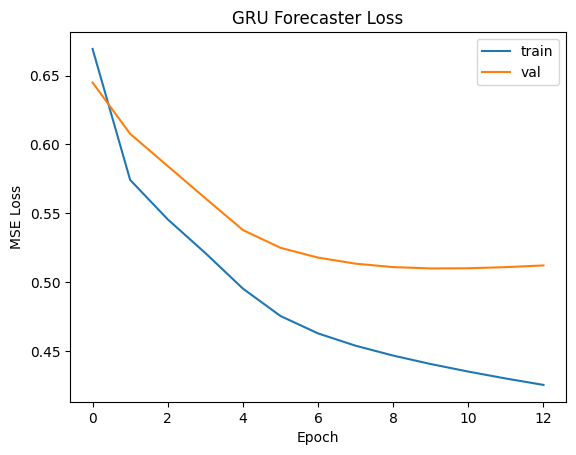

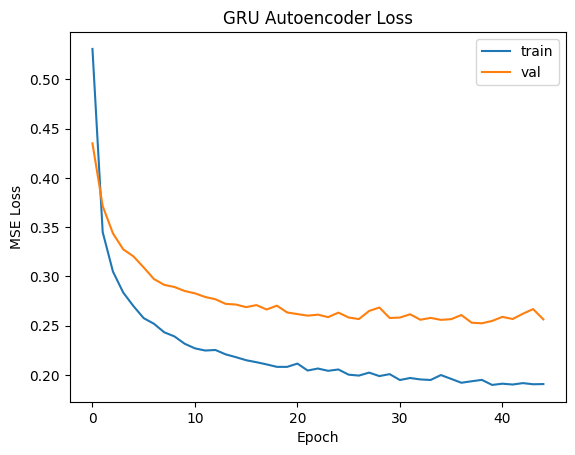

In [22]:
# Loss curves: Forecaster
plt.figure()
plt.plot(hist_f.history["loss"], label="train")
plt.plot(hist_f.history["val_loss"], label="val")
plt.title("GRU Forecaster Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

#Loss curves: Autoencoder
plt.figure()
plt.plot(hist_ae.history["loss"], label="train")
plt.plot(hist_ae.history["val_loss"], label="val")
plt.title("GRU Autoencoder Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


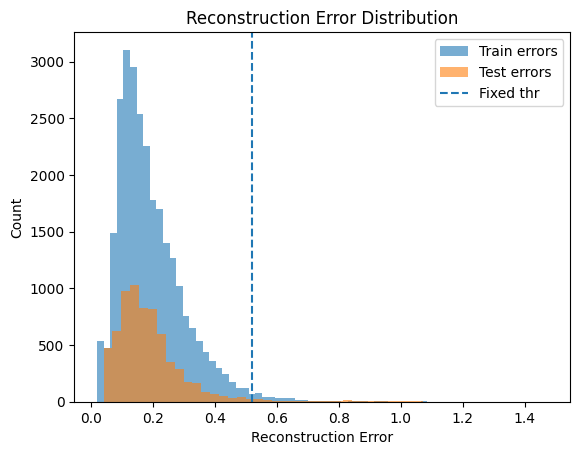

In [23]:
plt.figure()
plt.hist(train_err, bins=50, alpha=0.6, label="Train errors")
plt.hist(test_err, bins=50, alpha=0.6, label="Test errors")
plt.axvline(thr_fixed, linestyle="--", label="Fixed thr")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()


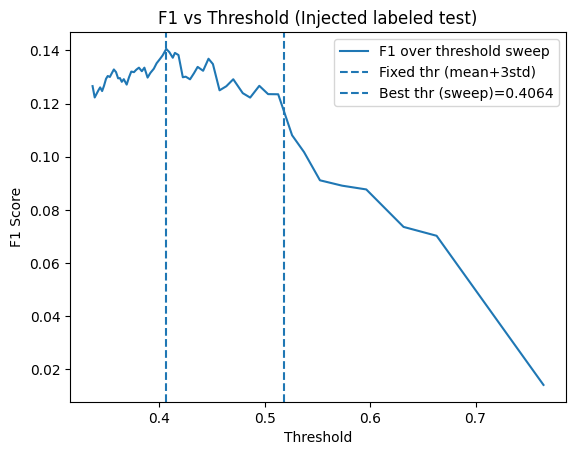

Best threshold from sweep: 0.4064437588089603 Best F1: 0.14057507987220447


In [24]:
#Sweep thresholds across percentiles of training errors
ths = np.percentile(train_err, np.linspace(90, 99.9, 60))

f1s = []
for t in ths:
    yhat = (inj_err > t).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_true, yhat, average="binary", zero_division=0)
    f1s.append(f)

best_i = int(np.argmax(f1s))
best_thr = ths[best_i]
best_f1 = f1s[best_i]

plt.figure()
plt.plot(ths, f1s, label="F1 over threshold sweep")
plt.axvline(thr_fixed, linestyle="--", label="Fixed thr (mean+3std)")
plt.axvline(best_thr, linestyle="--", label=f"Best thr (sweep)={best_thr:.4f}")
plt.title("F1 vs Threshold (Injected labeled test)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

print("Best threshold from sweep:", best_thr, "Best F1:", best_f1)


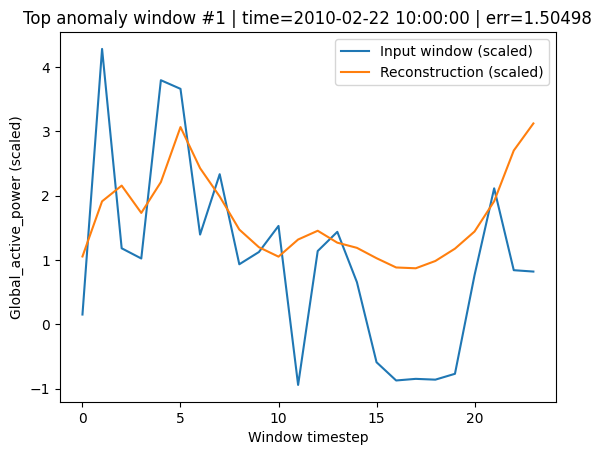

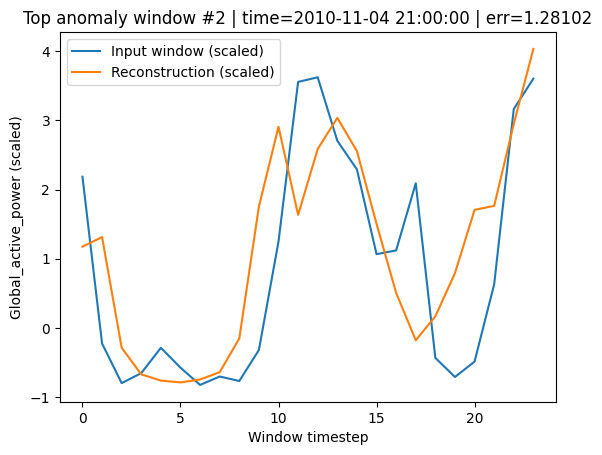

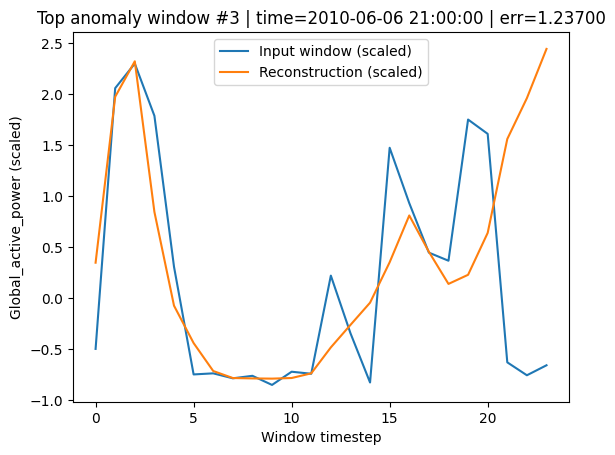

In [25]:
# Pick top-K anomaly windows by reconstruction error
K = 3
top_idx = np.argsort(-inj_err)[:K]

# Reconstruct those windows
Xhat_top = ae_paper.predict(Xa_inj[top_idx], verbose=0)

#Plot only the main target feature inside the window
target_feat_name = target_col
feat_index = list(test_inj_feat2.columns).index(target_feat_name)

for j, k in enumerate(top_idx):
    plt.figure()
    plt.plot(Xa_inj[k, :, feat_index], label="Input window (scaled)")
    plt.plot(Xhat_top[j, :, feat_index], label="Reconstruction (scaled)")
    plt.title(f"Top anomaly window #{j+1} | time={idxa_inj[k]} | err={inj_err[k]:.5f}")
    plt.xlabel("Window timestep")
    plt.ylabel(target_col + " (scaled)")
    plt.legend()
    plt.show()


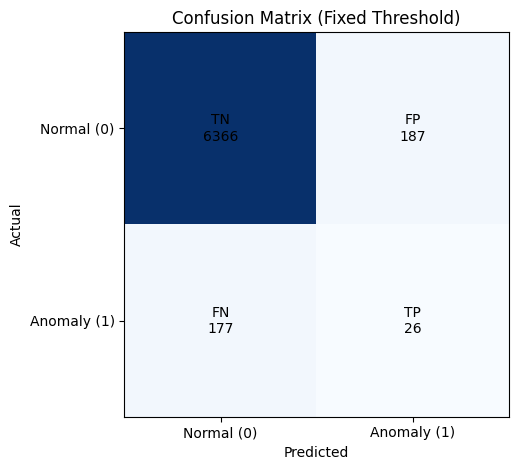

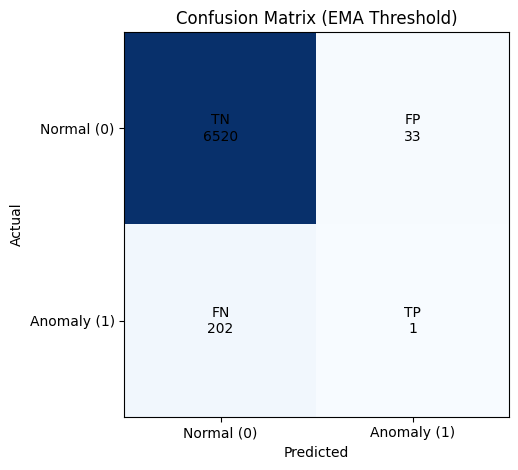

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def show_cm(cm, title, save_path=None):
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.xticks([0, 1], ["Normal (0)", "Anomaly (1)"])
    plt.yticks([0, 1], ["Normal (0)", "Anomaly (1)"])

    # Add cell labels + values
    labels = np.array([["TN", "FP"],
                       ["FN", "TP"]])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, f"{labels[i,j]}\n{cm[i,j]}", ha="center", va="center")

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

# Visualize + save both confusion matrices
show_cm(cm_fixed, "Confusion Matrix (Fixed Threshold)", "cm_fixed_threshold.png")
show_cm(cm_dyn,   "Confusion Matrix (EMA Threshold)",   "cm_ema_threshold.png")
